

```
# This is formatted as code
```

# Час-пик в Лондоне

В работе приводится пример обработки данных из открытых источников с помощью распространенных библиотек языка программирования Python. Пример рассмотрен на данных о загрузке общественного транспорта в Лондоне: сети метро и сети автобусов, -- который соответствует трем важным характеристикам:

1) Данные находятся в открытом доступе под лицензией на свободное использование, что важно для принципиальной возможности рассмотрения их в рамках проекта без специального разрешения;

2) Данные содержат качественные и количественные признаки дней-"объектов" -- это позволило продемонстрировать разные возможности библиотеки pandas;

3) Данные адаптированы для переноса в формат таблиц Excel, что позволило сравнить два инструмента.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Загрузка данных

Загрузим датасет о поездках на общественном транспорте Лондона в 2022 году. Данные открытые и публикуются на сайте http://crowding.data.tfl.gov.uk/ [дата обращения: 26.04.2024]

Для запуска ноутбука на Google Colab самый простой способ загрузить данные -- через ссылку на файл с данными на вашем Google Drive:

1) Положите в директорию на Google Drive (называется My Drive) файл, приложенный к этому ноутбуку;

2) Затем откройте файл для редакции по ссылке "Всем, у кого есть ссылка", скопируйте и вставьте в первую строку в блоке;

3) При необходимости запустить ноутбук локально через Anaconda используйте закомментированные две строки блока, предварительно разместив данные в одной с ноутбуком директории.

In [2]:
url='https://drive.google.com/file/d/1zrsp-2nOE1r-U_CspmIwSGIEjpXlLXZa/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url, index_col='TravelDate')

#Если запускаете ноутбук локально:
#data = pd.read_csv('titanic_data.csv', index_col='PassengerId')

In [3]:
basic_features = data.columns

print(f'Всего {len(data)} дней в выборке')
data.head()

Всего 365 дней в выборке


,DayOFWeek,TubeJourneyCount,BusJourneyCount
TravelDate,,,
20220101,Saturday,973000,1787000
20220102,Sunday,1119000,2135000
20220103,Monday,1121000,2413000
20220104,Tuesday,1491000,3351000
20220105,Wednesday,1686000,3819000


## Описательные метрики

С помощью кода выше мы загрузили данные таким образом, что индивидуальными объектами являются даты 2022 года, а остальные три столбца -- признаками. Это важно, так как значения некоторых признаков могут повторяться (простой пример -- повторяющиеся дни недели), но нам важна каждая точка в данных и отсутствие риска перепутать их между собой.

Дни недели это качественный признак, количество поездок -- количественный.

Дальнейший подсчет статистики использования той или иной сети общественного транспорта начинается с базового описания количественных данных: подсчет средних значений, отклонений, минимума, максимума и квантилей.

Квантили, особенно подсчет 50% важны, так как значение среднего из-за отклонений не дает представления о форме "колокола" -- графика распределения данных. Квантиль 50% -- это так называемая медиана, характеристика среднего по номеру значения в упорядоченном ряду всех значений, и в вопросе распределения дает более надежное представление о данных.

In [4]:
data.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,TubeJourneyCount,BusJourneyCount
count,365.00,365.00
mean,2633709.59,4335095.89
std,681740.76,844525.57
min,0.00,1000.00
25%,2242000.00,3968000.00
50%,2744000.00,4515000.00
75%,3095000.00,5024000.00
max,4032000.00,5900000.00


Распределение данных можно понять, если визуализировать их в виде гистограммы:

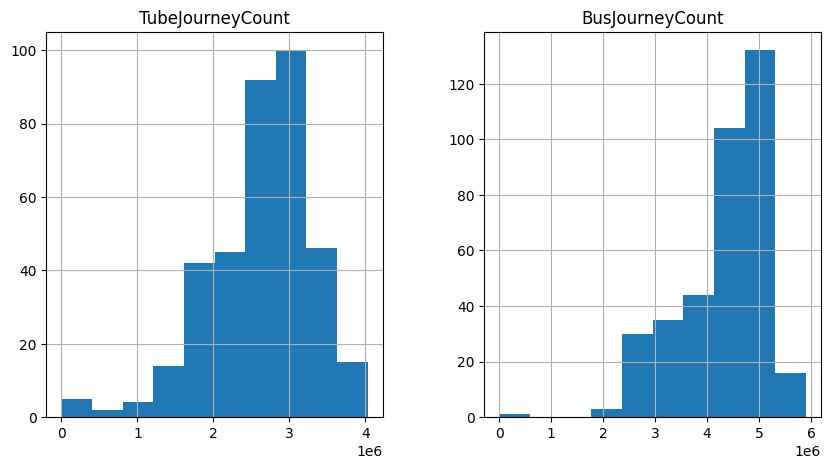

In [5]:
data.hist(data.columns, figsize=(10, 5));

Расчет описательных метрик можно применять не только к общему массиву данных, но и для определенных групп. При работе с инструментами обработки баз данных (pandas) для этого необходимо использовать череду методов.

Ниже мы выделяем из исходной две под-базы: содержащую среднюю и медианную загруженности транспортных подсистем по дням недели.


In [6]:
data[["DayOFWeek", "BusJourneyCount", "TubeJourneyCount"]].groupby("DayOFWeek").mean().apply(lambda s: s.apply('{0:.2f}'.format))
meanFrame = data[["DayOFWeek", "BusJourneyCount", "TubeJourneyCount"]].groupby("DayOFWeek").mean().apply(lambda s: s.apply('{0:.2f}'.format))
meanFrame.rename(columns={"BusJourneyCount": "BusJourneyMean", "TubeJourneyCount": "TubeJourneyMean"}, inplace=True)

Важная часть преобразования -- переименование столбцов. Это понадобится нам чуть ниже для того, чтобы была возможность построить корректную сводную таблицу и читаемые графики:

In [7]:
data[["DayOFWeek", "BusJourneyCount", "TubeJourneyCount"]].groupby("DayOFWeek").median().apply(lambda s: s.apply('{0:.2f}'.format))
medianFrame = data[["DayOFWeek", "BusJourneyCount", "TubeJourneyCount"]].groupby("DayOFWeek").median().apply(lambda s: s.apply('{0:.2f}'.format))
medianFrame.rename(columns={"BusJourneyCount": "BusJourneyMedian", "TubeJourneyCount": "TubeJourneyMedian"}, inplace=True)

Объединяем подтаблицы по дням недели:

In [8]:
frames = [meanFrame, medianFrame]
statData = pd.concat(frames, axis=1)
pd.concat(frames, axis=1)

,BusJourneyMean,TubeJourneyMean,BusJourneyMedian,TubeJourneyMedian
DayOFWeek,,,,
Friday,4837692.31,2846500.00,5013500.00,2895500.00
Monday,4375230.77,2454211.54,4616000.00,2556000.00
Saturday,3999283.02,2587264.15,4103000.00,2607000.00
Sunday,2852653.85,1802750.00,2932000.00,1855000.00
Thursday,4815423.08,2973500.00,4942500.00,3093500.00
Tuesday,4702538.46,2793038.46,4814500.00,2916000.00
Wednesday,4769307.69,2979596.15,4848500.00,2984500.00


Объединенная таблица позволяет сравнить, что значение медианы действительно лучше отражает форму распределения.

## Визуализация данных

Непосредственно библиотека pandas не дает инструментов для работы с наглядным представлением данных. Для того, чтобы визуализировать приведенные выше распределения, необходимо обратиться к библиотекам matplotlib и seaborn, широко распространенным среди пользователей самого разного уровня, включая ученых, публикующихся в Nature:

<ipython-input-9-fe57e77e8ebc>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='BusJourneyCount', y='DayOFWeek', inner='stick', palette='Dark2')


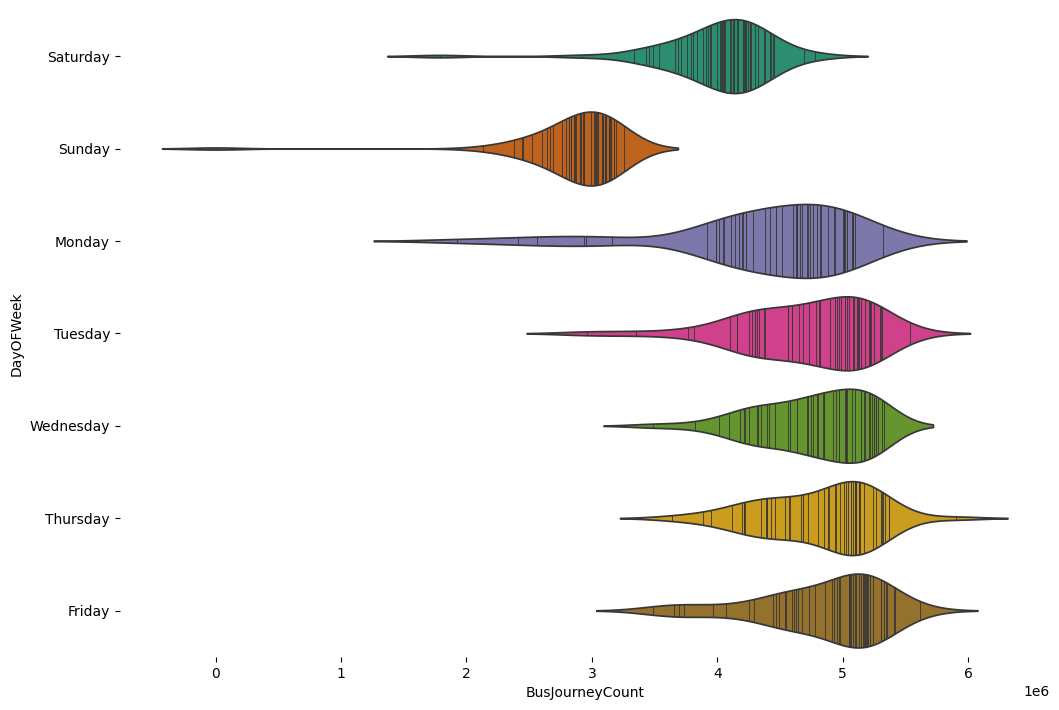

In [9]:
# @title Нагрузка на автобусную сеть по дням недели

figsize = (12, 1.2 * len(data['DayOFWeek'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='BusJourneyCount', y='DayOFWeek', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-10-6f4759675b86>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='TubeJourneyCount', y='DayOFWeek', inner='stick', palette='Dark2')


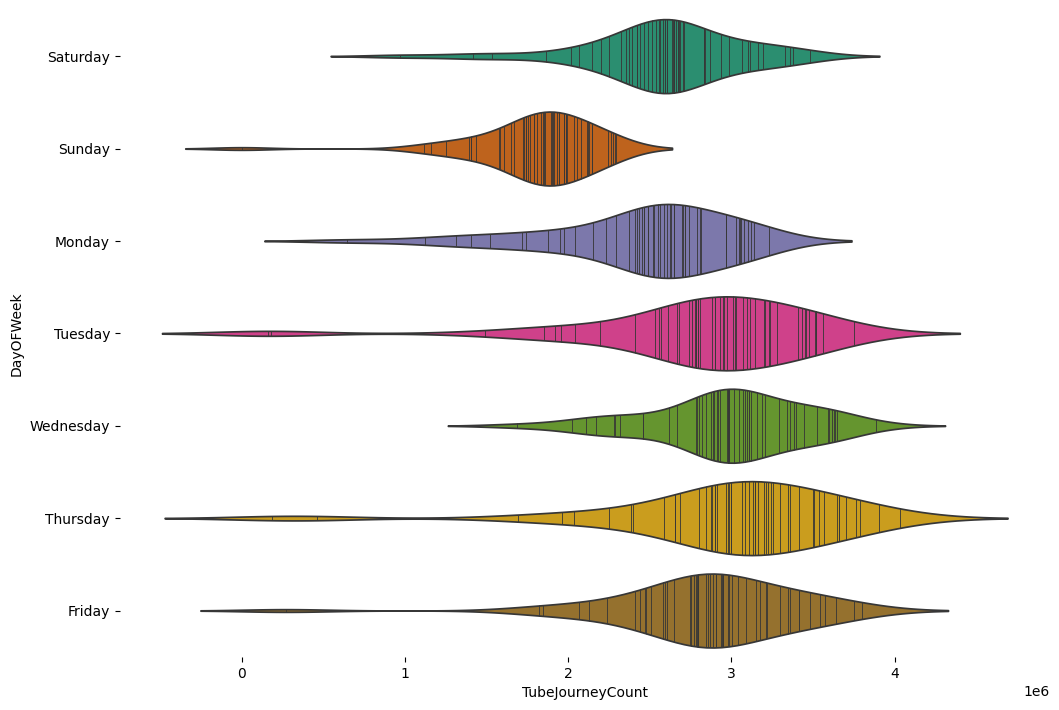

In [10]:
# @title Нагрузка на сеть метро по дням недели

figsize = (12, 1.2 * len(data['DayOFWeek'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='TubeJourneyCount', y='DayOFWeek', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Графическое отображение данных позволяет визуально оценить нагрузку на транспортные сети как совпадающую с ожиданиями обывателя: на выходных транспортом пользуются меньше. Но для того, чтобы утверждать однозначно, необходимо провести статистическую обработку данных. Это тема для отдельного проекта, который может быть реализован в дальнейшем.

# Торнадо из данных

Представленные выше метрики дают полное представление о структуре нагрузки на транспортные сети по отдельности, но не позволяют провести полноценное визуальное **сравнение**.

Для сравнительного представления по рекомендациям для нашего типа данных от [Data Viz Project](https://datavizproject.com/about/) был выбран **Butterfly plot**

In [19]:
visualData = pd.DataFrame({
    'BusJourney': [4616.0, 4814.5, 4848.5, 4942.5, 5013.5, 4103.0, 2932.0],
    'TubeJourney': [2526.0, 2916.0, 2984.5, 3093.5, 2895.5, 2607.0, 1855.0]
}, index=['Monday', 'Tuesday', 'Wednsday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

visualData

,BusJourney,TubeJourney
Monday,4616.0,2526.0
Tuesday,4814.5,2916.0
Wednsday,4848.5,2984.5
Thursday,4942.5,3093.5
Friday,5013.5,2895.5
Saturday,4103.0,2607.0
Sunday,2932.0,1855.0


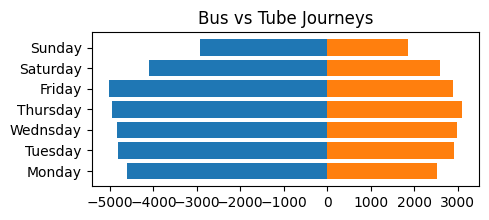

In [22]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=100)

(l1, x1), (l2,x2) = visualData.items()

y = range(len(x1))
labels = visualData.index.tolist()
plt.yticks(y, labels)

plt.barh(y=y, width=-x1)
plt.barh(y=y, width=x2)

plt.title('Bus vs Tube Journeys at week')
plt.show()

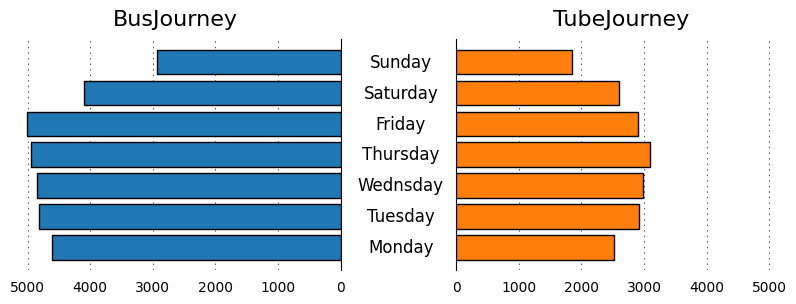

In [23]:
import matplotlib.ticker as mtick
import matplotlib.transforms as transforms

def butterfly_chart(
        data: pd.DataFrame,
        title: str = None,
        middle_label_offset=0.01,
        figsize=(5, 2),
        wspace=0.6
    ):
    """ """

    plt.rcParams.update({
        # general
        'figure.facecolor': 'w',
        # font sizes
        'font.size': 12,
        'axes.titlesize': 16,
        'xtick.labelsize': 10,
        # force black border
        'patch.force_edgecolor': True,
        'patch.facecolor': 'black',
        # remove spines
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.bottom': False,
        'xtick.top': False,
        'axes.titlepad': 10,
        # grid
        'axes.grid': True,
        'grid.color': 'k',
        'grid.linestyle': ':',
        'grid.linewidth': 0.5,
        'lines.dotted_pattern': [1, 3],
        'lines.scale_dashes': False
    })

    fig, (ax1, ax2) = plt.subplots(
        figsize=figsize,
        dpi=100,
        nrows=1,
        ncols=2,
        subplot_kw={'yticks': []},
        gridspec_kw={'wspace': wspace},
    )


    # plot the data
    (l1, x1), (l2,x2) = data.items()
    y = range(len(x1))
    labels = data.index.tolist()

    ax1.barh(y=y, width=x1, color='tab:blue', zorder=3)
    ax1.invert_xaxis()
    ax1.set_title(l1)

    ax2.barh(y=y, width=x2, color='tab:orange', zorder=3)
    ax2.set_title(l2)

    # forced shared xlim
    x_max = max(ax1.get_xlim()[0], ax2.get_xlim()[0])
    ax1.set_xlim((x_max, 0))
    ax2.set_xlim((0, x_max))

    # turn on axes spines on the inside y-axis
    ax1.spines['right'].set_visible(True)
    ax2.spines['left'].set_visible(True)

    # format axes
    #xfmt = mtick.PercentFormatter(xmax=1, decimals=0)
    #ax1.xaxis.set_major_formatter(xfmt)
    #ax2.xaxis.set_major_formatter(xfmt)

    # place center labels
    transform = transforms.blended_transform_factory(fig.transFigure, ax1.transData)
    for i, label in enumerate(labels):
        ax1.text(0.5+middle_label_offset, i, label, ha='center', va='center', transform=transform)

    plt.suptitle(title, y=1.05, fontsize='x-large')


butterfly_chart(
    visualData,
    figsize=(10, 3),
    wspace=0.35,
    middle_label_offset=0.015,
    #title='Bus vs Tube Journeys at week'
)

## Выводы

Приведенный ноутбук составлен, преимущественно, как методическое практическое пособие по работе с данными типа DataFrame с помощью библиотеки обработки pandas и графических модулей библиотеки matplotlib.

Таким образом он может быть транспонирован на любые данные, имеющиеся у пользователя.